In [ ]:
%matplotlib notebook

In [1]:
import numpy as np
from mpmath import zetazero

from sympy import nextprime, re, im

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from celluloid import Camera
from matplotlib import animation
from IPython.display import HTML

In [ ]:
import matplotlib
matplotlib.use("TkAgg")

### Get zeros of Zeta function

reading from table online

https://math.stackexchange.com/questions/2640941/how-to-locate-zeros-of-the-riemann-zeta-function

https://www-users.cse.umn.edu/~odlyzko/zeta_tables/

In [2]:
from urllib.request import urlopen

url = 'https://www-users.cse.umn.edu/~odlyzko/zeta_tables/zeros1'

gammas = urlopen(url).read().decode('utf-8').split()
print(len(gammas))

# only taking the first 200 and converting to 0.5 + iγ
zeta_zeros = [.5 + 1j*float(gamma) for gamma in gammas[:200]]

100000


computing using mpmath

https://mpmath.org/doc/current/functions/zeta.html

In [ ]:
zeta_zeros = [zetazero(i) for i in tqdm(range(1,201))]
zeta_zeros = [float(i.real) + 1j*float(i.imag) for i in zeta_zeros]

### Chebyshev function

$$ \psi(x) = \sum_{k\in\mathbb{N}} \sum_{p^{k}\leq x} \ln p
= \sum_{n\leq x} \Lambda (n)
= \sum_{p\leq x} \lfloor \log_p x \rfloor \ln p $$

$$ \psi_0(x) = x - \sum_{\rho}\frac{x^\rho}{\rho}
- \sum_{m=1}^{\infty} \frac{x^{-2m}}{-2m}
- \log(2\pi)  $$

$$ \psi_0(x) = x - \sum_{\rho}\frac{x^\rho}{\rho} - \frac{1}{2}\log(1-x^{-2}) - \log(2\pi) $$

In [4]:
def primepsi(x):
  p = 2
  sum_ = 0
  while p <= x:
    sum_ += np.floor(np.math.log(x, p)) * np.log(p)
    p = nextprime(p)
  return sum_


def psi_0(x, n_non_trivial=None):
  y = x

  # sum over non-trivial zeros
  sum_ = 0
  for z in zeta_zeros[:n_non_trivial]:
    gamma = float(im(z))
    z_conj = 1 - z
    term = (x**z) / z
    term += (x**z_conj) / z_conj
    # term = 2*term
    sum_ += term
  y = y - sum_

  y -= np.log(2*np.pi)
  y -= 0.5 * np.log(1-(1/(x*x)))
  
  if hasattr(y, '__iter__'):
    y = np.array(list(map(re, y)))
  else:
    y = re(y)
  return y

print(primepsi(100))
print(psi_0(100))

94.0453112293574
93.7217251276631


#### Approximating the chebyshev function

Approximating the trivial zeros contribution
$$ \sum_{m=1}^{\infty} \frac{x^{-2m}}{-2m} = \frac{1}{2}\log(1-x^{-2}) $$

Approximating the non-trivial zeros contribution
$$ x^{\frac{\rho}{n}} + x^{\frac{\overline\rho}{n}} = 2\Re (x^{\frac{\rho}{n}}) $$
summing over conjugate pairs
$$ 2\Re \left(\frac{x^{1/2+i\gamma}}{1/2+i\gamma}\right)
\approx 4\sqrt{x} \left(\frac{\cos(\gamma\log(x)) + 2\gamma\sin(\gamma\log(x))}{1+4\gamma^{2}} \right)
\approx \sqrt{x} \left(\frac{2\sin(\gamma\log(x))}{\gamma} \right) $$

<br><br>

Approximating the chebyshev function
$$ \psi_0(x) = x - \sum_{\rho}\frac{x^\rho}{\rho}
-\sum_{m=1}^{\infty} \frac{x^{-2m}}{-2m}
-\log(2\pi)  $$

Substituting equations and approximations
$$ \psi_0(x) = x 
-\sqrt{x} \sum_{\gamma} \left(\frac{2\sin(\gamma\log(x))}{\gamma} \right)
-\frac{1}{2}\log(1-x^{-2}) - \log(2\pi) $$

In [5]:
# fastest that I could get

def psi_approx(x, n_non_trivial=None):
  y = x

  # sum over non-trivial zeros
  sum_ = 0
  
  # for z in zeta_zeros[:n_non_trivial]:
  #   gamma = float(im(z))
  #   term = np.cos(gamma*np.log(x))
  #   term += 2*gamma*np.sin(gamma*np.log(x))
  #   term /= 1 + 4*gamma*gamma
  #   sum_ += term
  # sum_ *= 4*np.sqrt(x)
  
  for z in zeta_zeros[:n_non_trivial]:
    gamma = float(im(z))
    term = 2*np.sin(gamma*np.log(x))
    term /= gamma
    sum_ += term
  sum_ *= np.sqrt(x)
  
  y = y - sum_

  y -= np.log(2*np.pi)
  y -= 0.5 * np.log(1-(1/(x*x)))  
  return y

print(primepsi(100))
print(psi_approx(100))

94.0453112293574
93.66179031760768


#### plot

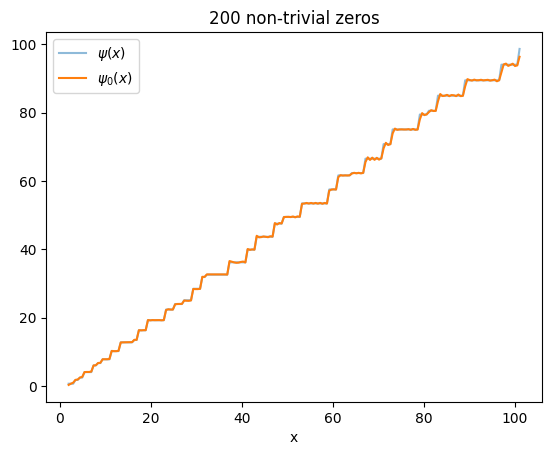

In [26]:
x = np.linspace(2,101,200)
n_non_trivial = 200

y_psi = list(map(primepsi, x))
plt.plot(x, y_psi, alpha=0.5, label='$\psi(x)$')

y_psi_appr = psi_approx(x, n_non_trivial=n_non_trivial)

plt.plot(x, y_psi_appr, label='$\psi_0(x)$')
plt.title(f'{n_non_trivial} non-trivial zeros')
plt.xlabel('x')
plt.legend()
plt.show()

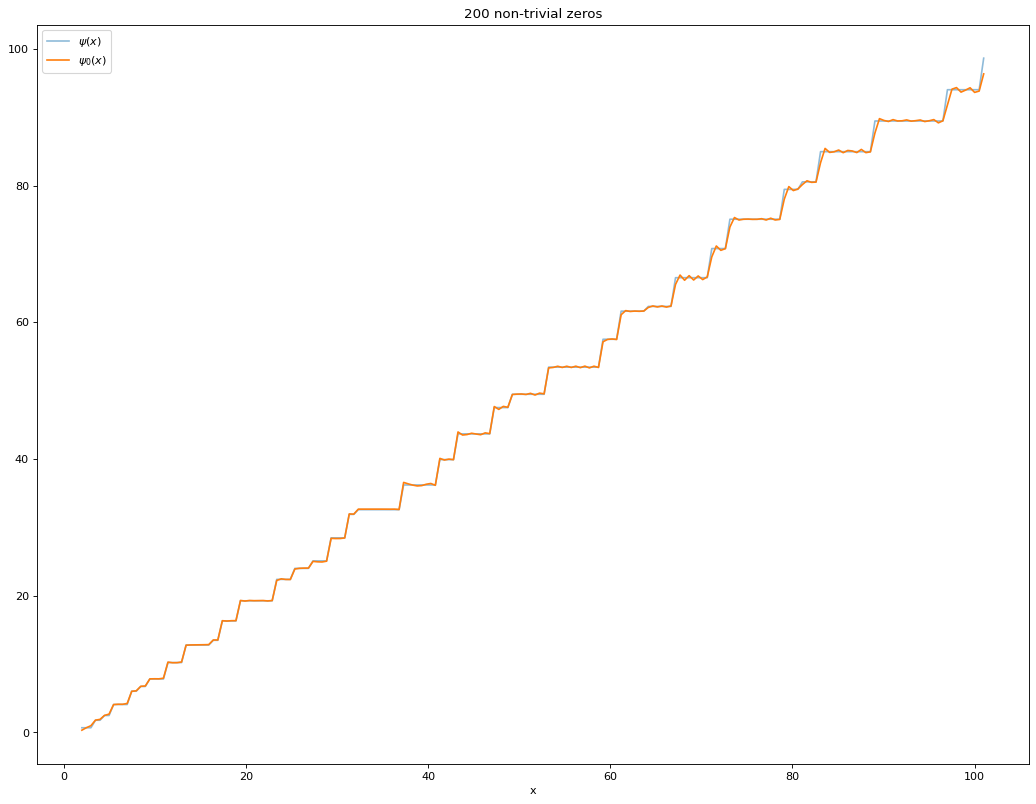

In [27]:
plt.figure(figsize=(16, 12), dpi=80)
plt.plot(x, y_psi, alpha=0.5, label='$\psi(x)$')
plt.plot(x, y_psi_appr, label='$\psi_0(x)$')
plt.title(f'{n_non_trivial} non-trivial zeros')
plt.xlabel('x')
plt.legend()
plt.show()

#### animation

In [8]:
x = np.linspace(2,101,200)
n_non_trivial = None # 101
n_list = list(range(1+len(zeta_zeros)))
n_list = n_list[:n_non_trivial]

psi_approx_vals = []
for n in tqdm(n_list):
  y = psi_approx(x, n_non_trivial=n)
  psi_approx_vals.append(y)
psi_approx_vals = np.array(psi_approx_vals, dtype=float)

  0%|          | 0/201 [00:00<?, ?it/s]

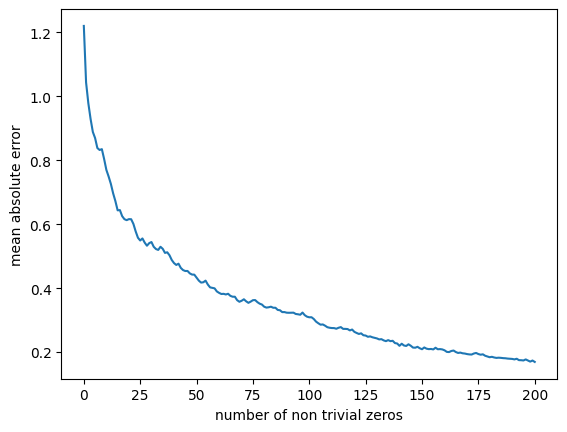

In [9]:
errs = (abs(list(map(primepsi, x))-psi_approx_vals)).mean(axis=1)
plt.xlabel('number of non trivial zeros')
plt.ylabel('mean absolute error')
plt.plot(n_list, errs)
plt.show()

In [16]:
y = list(map(primepsi, x))

def animate():
  fig = plt.figure()
  camera = Camera(fig)
  
  for i,n in enumerate(tqdm(n_list)):
    plt.text(10,80,f'{n} non-trivial zeros')
    plt.text(10,70,f'MAE: {errs[i]:.3f}')
    if i==0:
      plt.plot(x,y, alpha=0.5, c='#1f77b4', label='$\psi(x)$')
      plt.plot(x,psi_approx_vals[n], c='#ff7f0e', label='$\psi_0(x)$')
    else:
      plt.plot(x,y, alpha=0.5, c='#1f77b4')
      plt.plot(x,psi_approx_vals[n], c='#ff7f0e')  
    plt.xlabel('x')
    plt.legend(loc='lower right')
    camera.snap()
    
  return camera

In [ ]:
camera = animate()
anim = camera.animate()
anim.save(f'Psi0_{int(n_list[-1])}.gif', writer=animation.PillowWriter(fps=10))
_ = plt.show()

In [18]:
HTML(anim.to_jshtml(fps=10, default_mode='reflect'))

#### widget

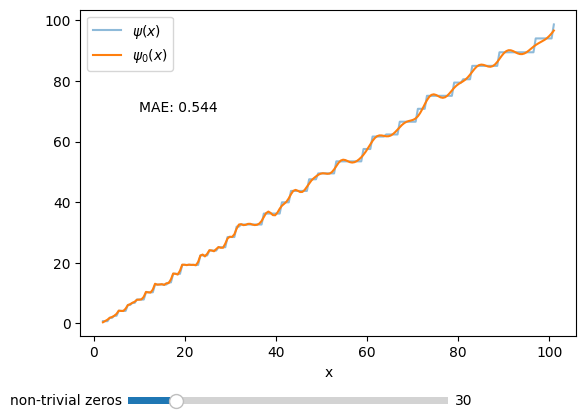

In [19]:
from matplotlib.widgets import Slider, Button

y = list(map(primepsi, x))
plt.plot(x,y, alpha=0.5, label='$\psi(x)$')
line, = plt.plot(x,y, label='$\psi_0(x)$')
text = plt.text(10,70,'MAE: ')
plt.xlabel('x')
plt.legend()

ax_nonTrivSlid = plt.axes([0.2, 0.05, 0.5, 0.03])
nonTriv_slider = Slider(ax_nonTrivSlid, 'non-trivial zeros', 0, 200, 30, valfmt="%i")


def update(val):
  n_nonTriv = int(nonTriv_slider.val)
  y = psi_approx_vals[n_nonTriv]
  line.set_ydata(y)
  text.set_text(f'MAE: {errs[n_nonTriv]:.3f}')


# Call update function when slider value is changed
update(None)
nonTriv_slider.on_changed(update)


plt.subplots_adjust(bottom=0.2)
plt.show()